In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import ParameterGrid
from torchvision import transforms, datasets
import numpy as np

In [2]:
class CNNnet(nn.Module):
    def __init__(self, filter_sizes, activation_function, drop_prob, normalise):
        super(CNNnet, self).__init__()

        self.normalise = normalise
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=filter_sizes[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=filter_sizes[2], out_channels=filter_sizes[3], kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[4], kernel_size=3, padding=1)

        # Batch Normalization layers
        self.bn1 = nn.BatchNorm2d(filter_sizes[0])
        self.bn2 = nn.BatchNorm2d(filter_sizes[1])
        self.bn3 = nn.BatchNorm2d(filter_sizes[2])
        self.bn4 = nn.BatchNorm2d(filter_sizes[3])
        self.bn5 = nn.BatchNorm2d(filter_sizes[4])
        self.activation_functions = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU()
        }

        self.activation = self.activation_functions[activation_function]

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer
        self.dropout = nn.Dropout(drop_prob)        

        self.flatten = nn.Flatten()

        # Fully connected layer
        self.fc = nn.Linear(filter_sizes[4], 10)

    def forward(self, x):
        # Apply layers with activation functions, batch normalization, and pooling
        for i in range(5):
            conv_layer = getattr(self, f'conv{i+1}')
            bn_layer = getattr(self, f'bn{i+1}')
            x = conv_layer(x)
            if(self.normalise):
                x = bn_layer(x)
            x = self.activation(x)
            if i < 4:  # Apply dropout after every pooling except the last convolutional layer
                x = self.pool(x)
                x = self.dropout(x)

        # Flatten and apply final fully connected layer
#         x = self.adaptive_pool(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [132]:
#Number of Parameters
FLOPs in a convolution :2x Number of Kernel x Kernel Shape x Output Shape

FLOPs in a fully connected layer: 2x Input Size x Output Size

FLOPs in a fully connected layer: height x depth x width of an image

conv 1 = 2x16x3x3x32x32 = 294912
conv 2 = 2x32x3x3x32x32 = 589824
conv 3 = 2x32x3x3x32x32 = 589824
conv 4 = 2x64x3x3x32x32 = 1179648
conv 5 = 2x64x3x3x32x32 = 1179648

FC1 = 2x64x10 = 1280

pool1: 32x16x32 = 16384
pool2: 32x32x32 = 32768
pool3: 32x32x32 = 32768
pool4: 32x64x32 = 65536
pool5: 32x64x32 = 65536

Total = 4,066,128

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    432     |
|  conv1.bias  |     16     |
| conv2.weight |    4608    |
|  conv2.bias  |     32     |
| conv3.weight |    9216    |
|  conv3.bias  |     32     |
| conv4.weight |   18432    |
|  conv4.bias  |     64     |
| conv5.weight |   36864    |
|  conv5.bias  |     64     |
|  bn1.weight  |     16     |
|   bn1.bias   |     16     |
|  bn2.weight  |     32     |
|   bn2.bias   |     32     |
|  bn3.weight  |     32     |
|   bn3.bias   |     32     |
|  bn4.weight  |     64     |
|   bn4.bias   |     64     |
|  bn5.weight  |     64     |
|   bn5.bias   |     64     |
|  fc.weight   |    640     |
|   fc.bias    |     10     |
+--------------+------------+
Total Trainable Params: 70826


70826

In [4]:
from tqdm import tqdm
def train_model(model, train_loader, criterion, optimizer,device, num_epochs = 5):
    for epoch in tqdm(range(num_epochs)):
        for inputs, labels in train_loader:
#             print("batch")
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

In [5]:
def eval_model(model,test_loader,device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [6]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])
device = torch.device('cuda')

In [7]:
train_dataset = datasets.ImageFolder('/kaggle/input/naturalist/inaturalist_12K/train', transform = transform)
test_dataset = datasets.ImageFolder('/kaggle/input/naturalist/inaturalist_12K/val', transform = transform)

In [9]:
np.random.seed(42)
indices = list(range(len(train_dataset)))
split = int(np.floor(0.1*len(train_dataset)))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [10]:
Train_Loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
Val_Loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=val_sampler)

In [12]:
param_grid = {
    'filters': [[16,32,32,64,64], [8,16,16,32,32]],
    'normalise': [True, False],
    'dropout': [0.2, 0.3],
}
accuracy_list = {}
param_list = {}
param_names = list(param_grid.keys())

In [13]:
i=0
for params in ParameterGrid(param_grid):
    print(f"parameters:{params}")
    model = CNNnet(params['filters'], 'relu', params['dropout'], params['normalise'])
    model.to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    print(f"training model here")
    # Train the model
    train_model(model, Train_Loader, criterion, optimizer,device, num_epochs=12)

    # Evaluate the model
    accuracy = eval_model(model, Val_Loader, device)

    # Store the results
    accuracy_list[i] = accuracy
    param_list[i] = params
    i = i+1
    # Print the results (you can modify this part based on your needs)
    print(f"Parameters: {params}, Accuracy: {accuracy}")



parameters:{'dropout': 0.2, 'filters': [16, 32, 32, 64, 64], 'normalise': True}
training model here


100%|██████████| 12/12 [16:50<00:00, 84.17s/it]


Parameters: {'dropout': 0.2, 'filters': [16, 32, 32, 64, 64], 'normalise': True}, Accuracy: 27.92792792792793
parameters:{'dropout': 0.2, 'filters': [16, 32, 32, 64, 64], 'normalise': False}
training model here


100%|██████████| 12/12 [15:40<00:00, 78.35s/it]


Parameters: {'dropout': 0.2, 'filters': [16, 32, 32, 64, 64], 'normalise': False}, Accuracy: 9.00900900900901
parameters:{'dropout': 0.2, 'filters': [8, 16, 16, 32, 32], 'normalise': True}
training model here


100%|██████████| 12/12 [16:13<00:00, 81.12s/it]


Parameters: {'dropout': 0.2, 'filters': [8, 16, 16, 32, 32], 'normalise': True}, Accuracy: 25.025025025025027
parameters:{'dropout': 0.2, 'filters': [8, 16, 16, 32, 32], 'normalise': False}
training model here


100%|██████████| 12/12 [16:15<00:00, 81.31s/it]


Parameters: {'dropout': 0.2, 'filters': [8, 16, 16, 32, 32], 'normalise': False}, Accuracy: 9.40940940940941
parameters:{'dropout': 0.3, 'filters': [16, 32, 32, 64, 64], 'normalise': True}
training model here


100%|██████████| 12/12 [16:18<00:00, 81.51s/it]


Parameters: {'dropout': 0.3, 'filters': [16, 32, 32, 64, 64], 'normalise': True}, Accuracy: 25.525525525525527
parameters:{'dropout': 0.3, 'filters': [16, 32, 32, 64, 64], 'normalise': False}
training model here


100%|██████████| 12/12 [16:14<00:00, 81.18s/it]


Parameters: {'dropout': 0.3, 'filters': [16, 32, 32, 64, 64], 'normalise': False}, Accuracy: 10.21021021021021
parameters:{'dropout': 0.3, 'filters': [8, 16, 16, 32, 32], 'normalise': True}
training model here


100%|██████████| 12/12 [16:17<00:00, 81.43s/it]


Parameters: {'dropout': 0.3, 'filters': [8, 16, 16, 32, 32], 'normalise': True}, Accuracy: 24.724724724724723
parameters:{'dropout': 0.3, 'filters': [8, 16, 16, 32, 32], 'normalise': False}
training model here


100%|██████████| 12/12 [16:15<00:00, 81.25s/it]


Parameters: {'dropout': 0.3, 'filters': [8, 16, 16, 32, 32], 'normalise': False}, Accuracy: 10.91091091091091


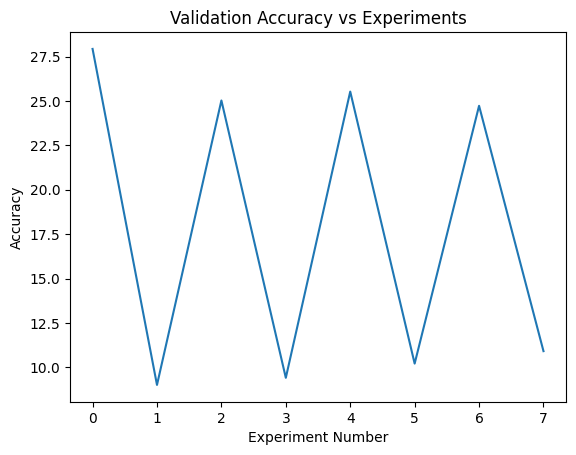

In [104]:
experiments = [0,1,2,3,4,5,6,7]
accuracies = []
for i in range(8):
    accuracies.append(accuracy_list[i])

import matplotlib.pyplot as plt
plt.title("Validation Accuracy vs Experiments")
plt.xlabel("Experiment Number")
plt.ylabel("Accuracy")
plt.plot(experiments, accuracies)
plt.show()

In [127]:
#TEST Accuracy
#best parameters: 0.2,[16,32,32,64,64], True
Test_Loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
model = CNNnet([16,32,32,64,64], 'relu', 0.2, True)
model.load_state_dict(torch.load('./model4.pth'))
model.to(device)
# train_model(model, Train_Loader, criterion, optimizer,device, num_epochs=10)
accuracy = eval_model(model, Test_Loader, device)
# torch.save(model.state_dict(), './model4.pth')
print(accuracy)

28.1


In [128]:
import random

total_indices = len(test_dataset)
random_indices = random.sample(range(total_indices), 30)  

inputs = torch.stack([test_dataset[i][0] for i in random_indices])
labels = torch.tensor([test_dataset[i][1] for i in random_indices])

inputs, labels = inputs.to(device), labels.to(device)

class_names = test_dataset.classes 
labels_text = [class_names[label] for label in labels.cpu().numpy()]


In [129]:
model.eval()
import torch.nn.functional as F

logits = model(inputs)
probabilities = F.softmax(logits, dim=1)
_, predictions = torch.max(probabilities, dim=1)


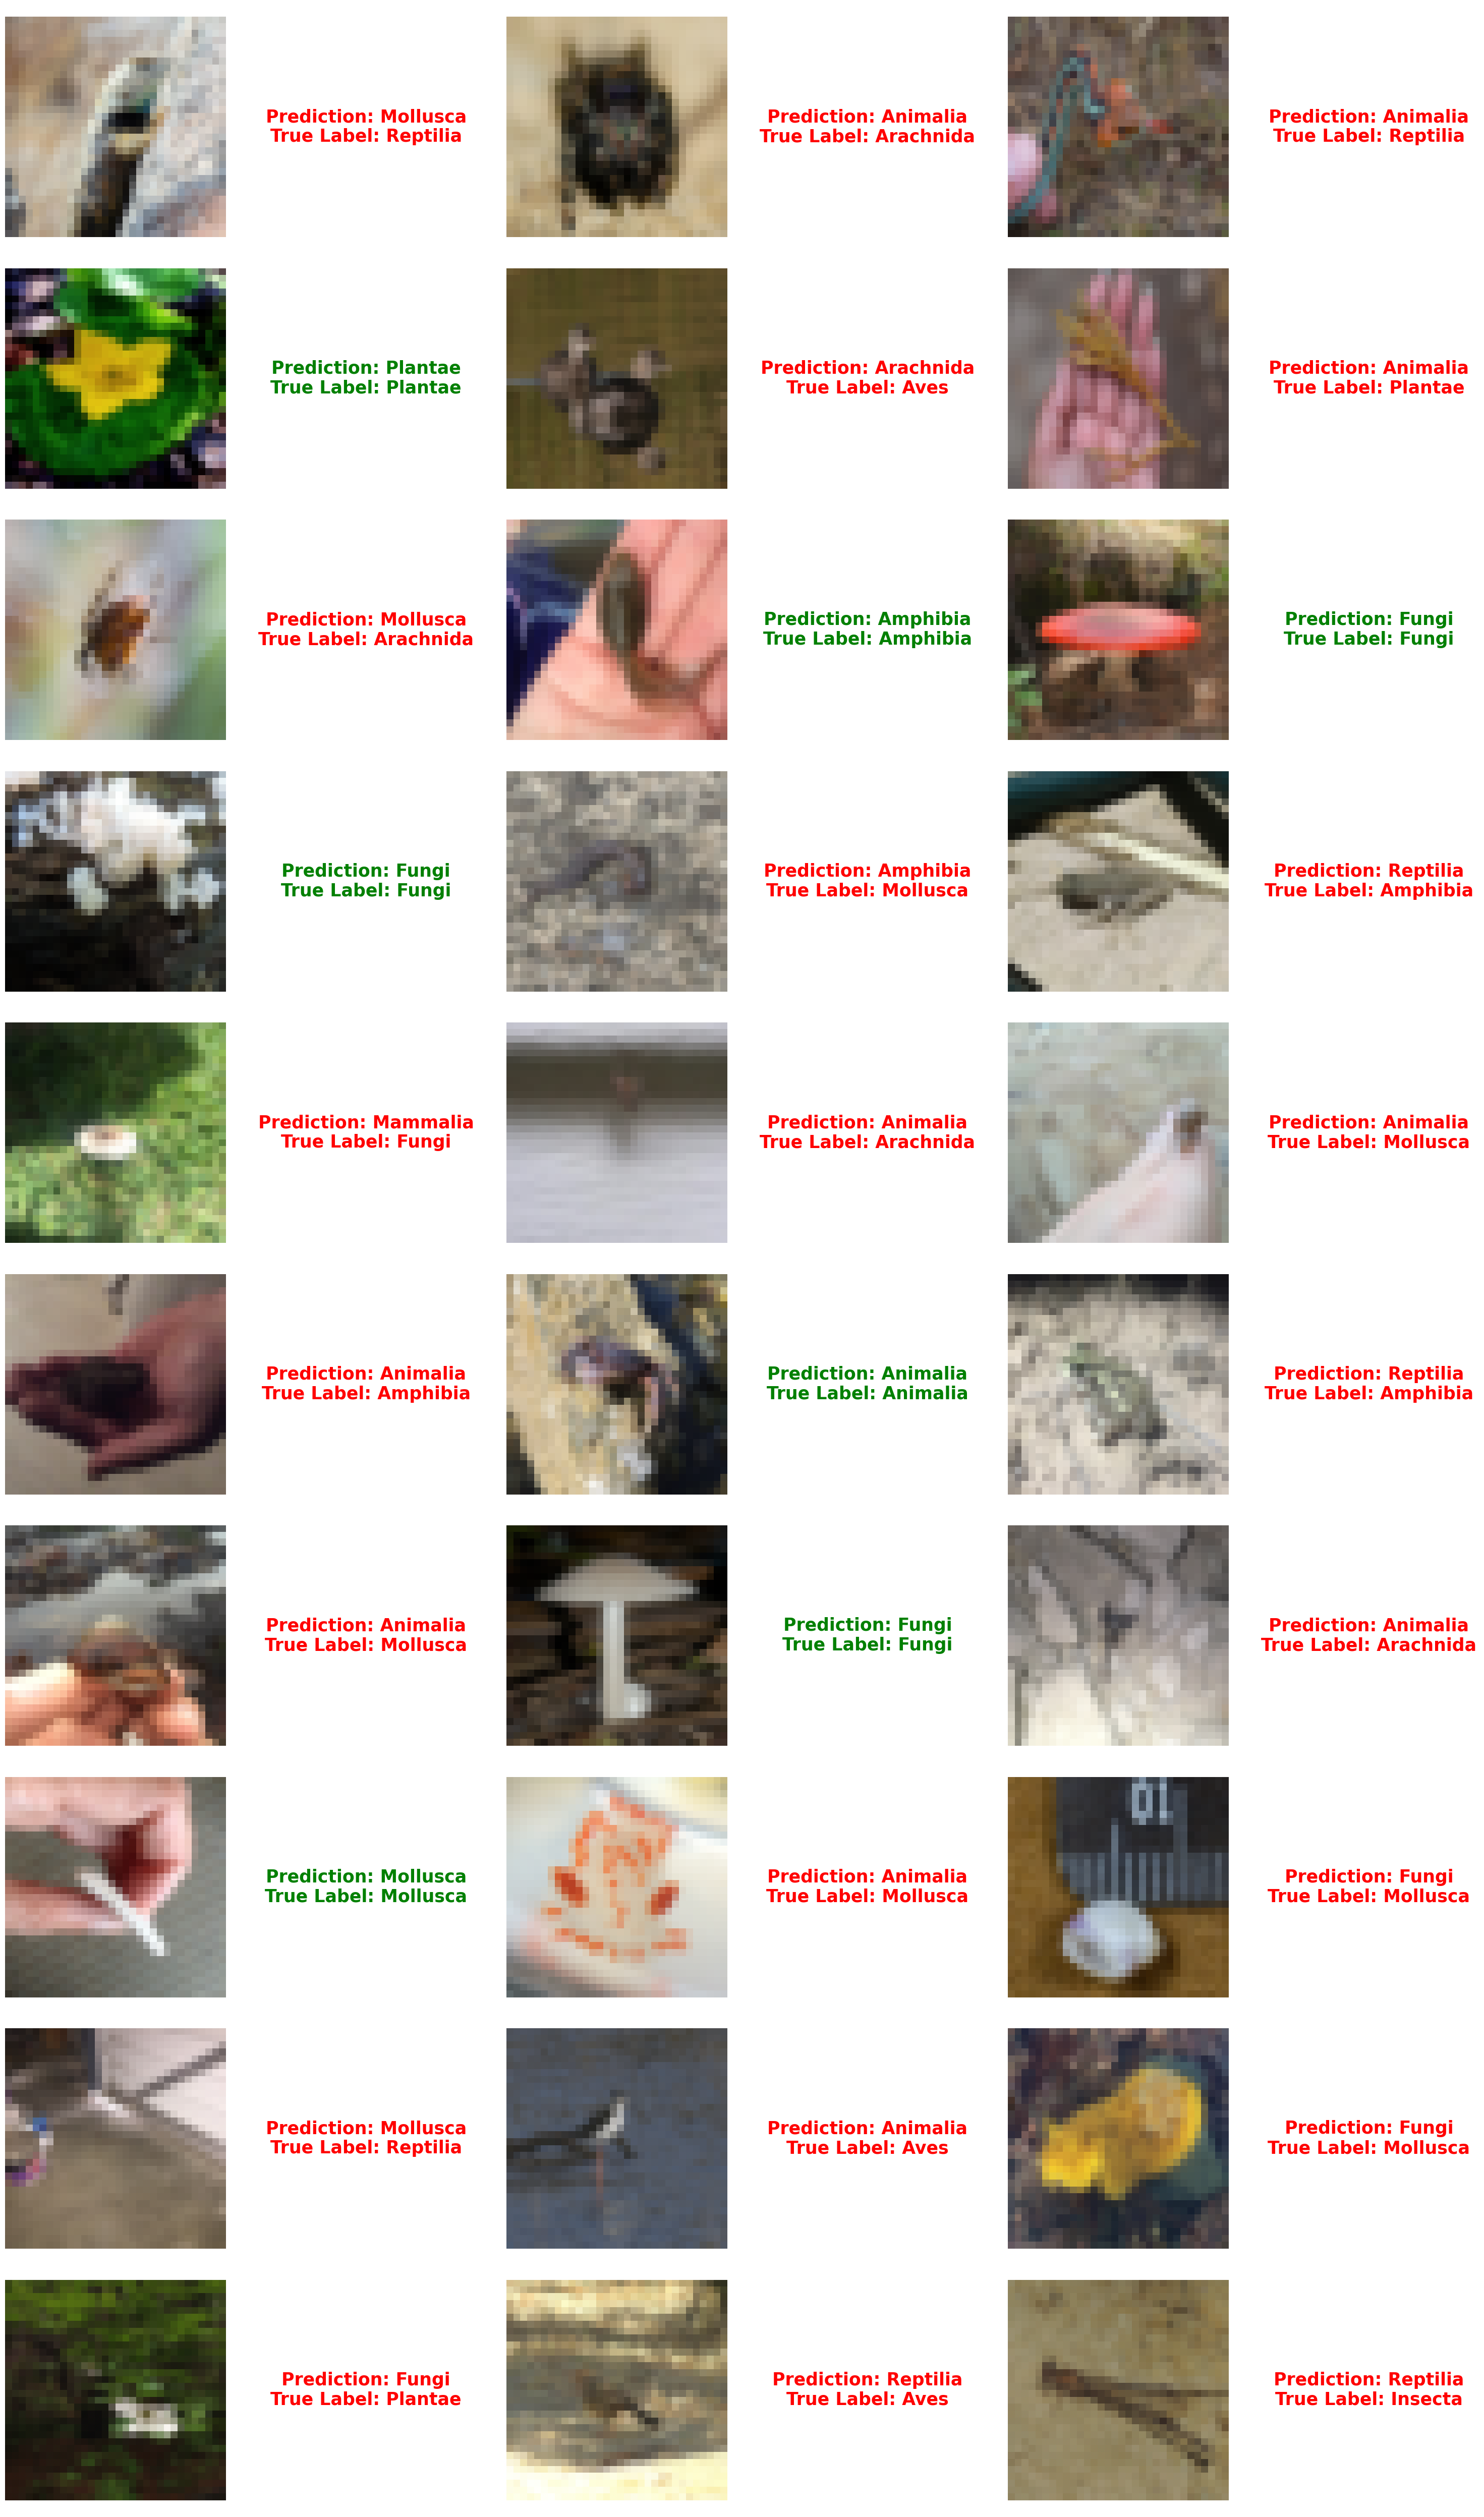

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def imshow(img, ax):
    img = img.cpu().numpy().transpose((1, 2, 0)) 
    ax.imshow(img)
    ax.axis('off')  

fig = plt.figure(figsize=(30, 50)) 

for idx in range(30):  
    ax_image = plt.subplot(10, 6, idx*2+1)
    imshow(inputs[idx], ax_image)  
    
    ax_text = plt.subplot(10, 6, idx*2+2, xticks=[], yticks=[])  
    ax_text.axis('off')  
    
    pred = predictions[idx].item()  
    true_label_text = labels_text[idx]  
    match = class_names[pred] == true_label_text
    
    text_color = "green" if match else "red"  
    
    text_str = f"Prediction: {class_names[pred]}\nTrue Label: {true_label_text}"
    
    patch = patches.Rectangle((0, 0), 1, 1, color='white', transform=ax_text.transAxes, alpha=0.6)
    ax_text.add_patch(patch)
    
    ax_text.text(0.5, 0.5, text_str, transform=ax_text.transAxes,
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=25, color=text_color, weight='bold')  

plt.tight_layout()
plt.show()


In [50]:
from collections import OrderedDict
from typing import Dict, Callable
import torch

def remove_all_forward_hooks(model: torch.nn.Module) -> None:
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_forward_hooks"):
                child._forward_hooks: Dict[int, Callable] = OrderedDict()
            remove_all_forward_hooks(child)

In [51]:
remove_all_forward_hooks(model)

In [52]:
feature_blobs = []
import numpy as np

def hook_feature1(module, input, output):
    feature_blobs.append(output.data.cpu().numpy())

model.conv1.register_forward_hook(hook_feature1)

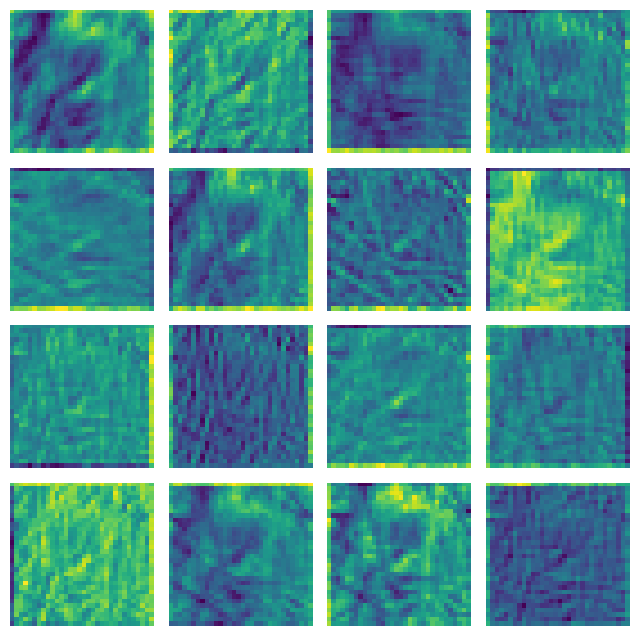

In [131]:
import matplotlib.pyplot as plt

filters = feature_blobs[0]  # Your existing line to select feature maps

fig, axs = plt.subplots(4, 4, figsize=(8, 8))  # Adjusted for a square layout

axs = axs.flatten()

for i in range(16):  # Assuming you want to display the first 16 filters
    axs[i].imshow(filters[i], cmap='viridis')  # Using a colormap for better visual distinction
    axs[i].axis('off')  # Remove axis labels and ticks for clarity

plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust spacing between plots to minimize
plt.savefig('./maps.jpg', bbox_inches='tight', pad_inches=0.1)  # Save the figure with tight layout
plt.show()  # Display the plot as output
